# Combining Data Delivery Methods

Several OOI data sets are delivered via different methods. These are defined by the means used to transfer the data to shore and on to CI. For the uncabled surface moorings, the methods are telemetered, recovered_host and recovered_inst. These are defined in the [README](https://github.com/oceanobservatories/ooi-data-explorations/tree/master/python#m2m-terminology) for this python code. Within a deployment, for a particular instrument, the data in the two or three different data delivery methods is ideally the same. However, due to differences in sampling rates, failures in telemetry, or issues with the recovered data, the most complete data set is often a combination of all the available delivered data rather than any single one of the above methods.

There are several other reasons why one would not want to just choose one of those data delivery methods as the default or "best" source of data. The two reasons that immediately come to mind are potential differences in the available parameters, and instrument clock drift. In the later case, telemetered and recovered_host data are referenced to a GPS conditioned and controlled clock, while instrument clocks may experience offsets (programmed to the wrong time zone) or drift.

This notebook will use the data from the Oregon Inshore Surface Mooring seafloor platform (or Multi-Function Node, MFN) CTD to demonstrate how to combine the data to create a single data set. The data was previously requested and downloaded using the [harvester script](../../../utilities/harvesters/harvest_ce_ctdbp.sh) and [python module](../../../ooi_data_explorations/uncabled/process_ctdbp.py) included with this code.

In [1]:
import glob
import numpy as np
import os
import sys
import xarray as xr

from ooi_data_explorations.combine_data import combine_datasets

In [12]:
# setup defaults used for the next steps
home = os.path.expanduser('~')
data_directory = os.path.join(home, 'ooidata/m2m/ce01issm/seafloor/ctdbp')
deployment = 8

Telemetery failed after 1.5 months during deployment 8, but the data logger system continued to operate and record data, as did the instrument itself. Using the glob module and the data_directory and deployment number defined above, find the data files with the data from the different data delivery methods.

In [25]:
# load the telemetered data file
tfile = glob.glob(os.path.join(data_directory, '*.deploy{:02d}.telemetered.*.nc'.format(deployment)))
tdata = xr.load_dataset(tfile[0])

# load the recovered_host data file
rhfile = glob.glob(os.path.join(data_directory, '*.deploy{:02d}.recovered_host.*.nc'.format(deployment)))
rhdata = xr.load_dataset(rhfile[0])

# load the recovered_inst data file
rifile = glob.glob(os.path.join(data_directory, '*.deploy{:02d}.recovered_inst.*.nc'.format(deployment)))
ridata = xr.load_dataset(rifile[0])

The combine_datasets function takes the telemetered and recovered_host data, concatenates the data records, and then keeps only the unique (based on the time stamp) records. Since these two data sets are identical, we don't want to double up the data record, just create a single data set covering the entire deployment. The recovered instrument data is then added to the record and the data is resampled onto a time interval of the users choosing. For this example, we will use 60 minutes.

In [26]:
help(combine_datasets)

Help on function combine_datasets in module ooi_data_explorations.combine_data:

combine_datasets(tdata, rhdata, ridata, resample_time)
    Load and merge data from telemetered, recovered host and recovered
    instrument data sets. Telemetered and recovered host data represent the
    same source of data, just different data delivery methods. These data files
    are concatenated together and only unique time records are kept. The
    recovered instrument data is concatenated onto the telemetered/recovered
    host data set and then the full data set is resampled to a common time
    record via median averaging. The resulting merged and resampled data set is
    returned for further analysis.
    
    :param tdata: telemetered data as an xarray data set
    :param rhdata: recovered host data as an xarray data set
    :param ridata: recovered instrument data as xarray data set
    :param resample_time: The resampling time period in minutes
    :return ds: The combined and resampled dat

In [34]:
# create a full data record from the telemetered, recovered_host and recovered_inst data and then resample
# it to an hourly record.
merged = combine_datasets(tdata, rhdata, ridata, 60)

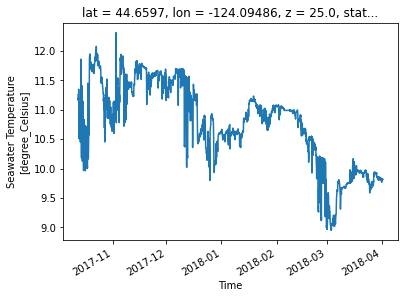

In [35]:
merged.temperature.plot()